# ANÁLISE 005 - COMPARATIVO VACINAÇÃO

1) A partir da planilha original (series_pandemia.xlsx), primeiro criei uma coluna de NOVOS IMUNIZADOS, somando as colunas NOVAS SEGUNDA DOSE e NOVAS DOSE UNICA.   

2) Criei mais duas colunas	
	
- uma de data efetiva  de imunizacao, deslocada 15 dias para a frente	
- uma de cidade da imunizaçao, copiando a coluna original de cidade	
- e já havia a coluna de numero de novos imunizados	
  .
  
Daí peguei essas 3 colunas e tirei da base priincipal, criando uma base separada IMUNIZADOS_SP;
a base principal ficou CASOS_SP.
  .
A partir daí farei o join dessas duas bases, amarrando por data e cidade, e (re)adicionando na primeira base a coluna novos imunizados da segunda.	

In [1]:
#imports necessários
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns 
%matplotlib inline
import pandas as pd
from datetime import datetime  
from datetime import timedelta  

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Leitura planilha de casos (previamente tratada e formatada)
df_casos = pd.read_excel("CASOS_SP.xlsx")
df_casos


,Data,Cidade,Taxa Isolamento,Novos Casos,Novos Óbitos
0,2021-02-01,Americana,0.36,3,0
1,2021-02-01,Araçatuba,0.35,52,1
2,2021-02-01,Araraquara,0.36,30,5
3,2021-02-01,Araras,0.36,88,0
4,2021-02-01,Arujá,0.34,57,0
...,...,...,...,...,...
16647,2021-07-31,Taubaté,0.40,185,1
16648,2021-07-31,Vargem Grande Paulista,0.46,0,0
16649,2021-07-31,Várzea Paulista,0.42,0,0
16650,2021-07-31,Votorantim,0.41,0,0


In [3]:
#Leitura planilha de imunizados (previamente tratada e formatada)
df_imunizados = pd.read_excel("IMUNIZADOS_SP.xlsx")
df_imunizados

,Data,Cidade,Novos_imunizados
0,2021-02-16,Americana,0
1,2021-02-16,Araçatuba,0
2,2021-02-16,Araraquara,0
3,2021-02-16,Araras,0
4,2021-02-16,Arujá,0
...,...,...,...
16647,2021-08-15,Taubaté,3
16648,2021-08-15,Vargem Grande Paulista,2
16649,2021-08-15,Várzea Paulista,2041
16650,2021-08-15,Votorantim,0


In [4]:
def converteTimestamp(df,col_data):

    lista = []

    for dt in df[col_data]:
        dti = datetime.strptime(str(dt), '%Y-%m-%d %H:%M:%S')
        lista.append(dti.strftime('%Y-%m-%d'))

    df[col_data] = lista
    
    return(df)

In [5]:
df_casos = converteTimestamp(df_casos,'Data')

A interpretação agora para a coluna "Novos_imunizados" é que é o número de pessoas que, EM MÉDIA, atingem a imunização completa na data indicada.

In [6]:
df_casos_imunizados = pd.merge(df_casos, df_imunizados, on=["Cidade","Data"], how="inner")
df_casos_imunizados

,Data,Cidade,Taxa Isolamento,Novos Casos,Novos Óbitos,Novos_imunizados
0,2021-02-16,Americana,0.38,52,5,0
1,2021-02-16,Araçatuba,0.36,99,2,0
2,2021-02-16,Araraquara,0.43,229,5,0
3,2021-02-16,Araras,0.39,0,1,0
4,2021-02-16,Arujá,0.38,0,0,0
...,...,...,...,...,...,...
15267,2021-07-31,Taubaté,0.40,185,1,59
15268,2021-07-31,Vargem Grande Paulista,0.46,0,0,7
15269,2021-07-31,Várzea Paulista,0.42,0,0,52
15270,2021-07-31,Votorantim,0.41,0,0,45


In [7]:
def normaliza_minmax(df,cols):
    for x in df[cols]:
        df[x] = (df[x] - df[x].min()) / (df[x].max() - df[x].min())
    return(df[cols])

In [8]:
def dados_munic(cidade):
    filtro_munic =(df_casos_imunizados['Cidade'] == cidade)
    dados = df_casos_imunizados[filtro_munic]
    return(dados)

In [9]:
cols = ['Taxa Isolamento','Novos Casos','Novos Óbitos','Novos_imunizados']
df_casos_imunizados[cols] = normaliza_minmax(df_casos_imunizados,cols)

In [17]:
def matriz_correlacoes(cidade):
    
    df = dados_munic(cidade)
    
    linha = "*"* 126
    print(linha)
    print("MAPA DE CORRELAÇÕES PARA CASOS E ÓBITOS X ISOLAMENTO E VACINAÇÃO PARA O MUNICÍPIO DE ",cidade, "\nPeríodo de",df_casos_imunizados['Data'].min(),"a", df_casos_imunizados['Data'].max())
    print("Fonte: Projeto COVID-19 Info Tracker")
    print(linha)
    
     
    #-----HEATMAP
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,annot=True)
    
    #-----CORRELATIONS
    g = sns.pairplot(df,diag_kind="kde",corner=True)
    g.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.figure(figsize=(20, 9))
    
    return  

******************************************************************************************************************************
MAPA DE CORRELAÇÕES PARA CASOS E ÓBITOS X ISOLAMENTO E VACINAÇÃO PARA O MUNICÍPIO DE  Americana 
Período de 2021-02-16 a 2021-07-31
Fonte: Projeto COVID-19 Info Tracker
******************************************************************************************************************************


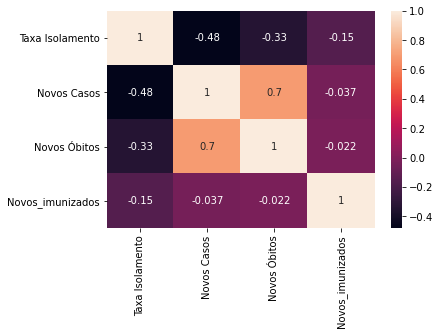

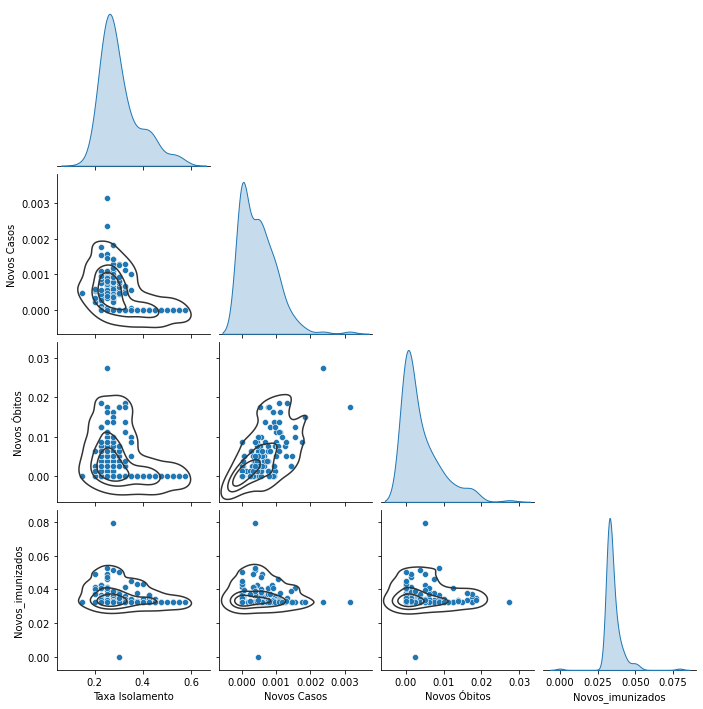

<Figure size 1440x648 with 0 Axes>

In [18]:
matriz_correlacoes("Americana")

******************************************************************************************************************************
MAPA DE CORRELAÇÕES PARA CASOS E ÓBITOS X ISOLAMENTO E VACINAÇÃO PARA O MUNICÍPIO DE  São Paulo 
Período de 2021-02-16 a 2021-07-31
Fonte: Projeto COVID-19 Info Tracker
******************************************************************************************************************************


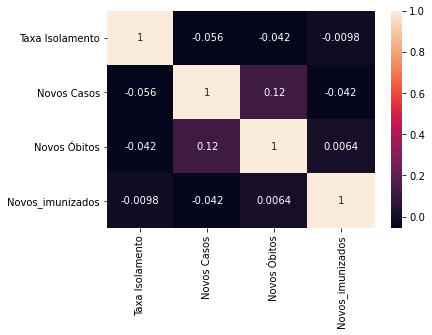

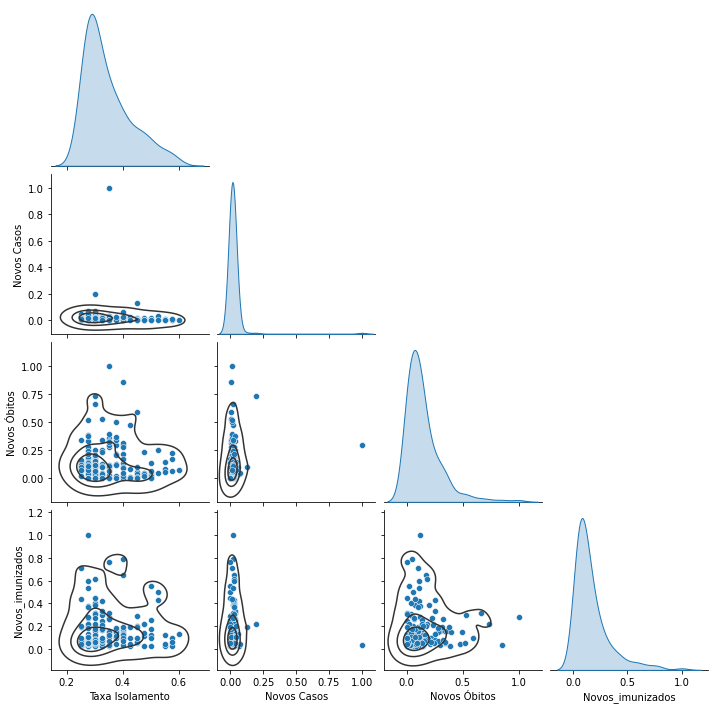

<Figure size 1440x648 with 0 Axes>

In [19]:
matriz_correlacoes("São Paulo")

******************************************************************************************************************************
MAPA DE CORRELAÇÕES PARA CASOS E ÓBITOS X ISOLAMENTO E VACINAÇÃO PARA O MUNICÍPIO DE  Botucatu 
Período de 2021-02-16 a 2021-07-31
Fonte: Projeto COVID-19 Info Tracker
******************************************************************************************************************************


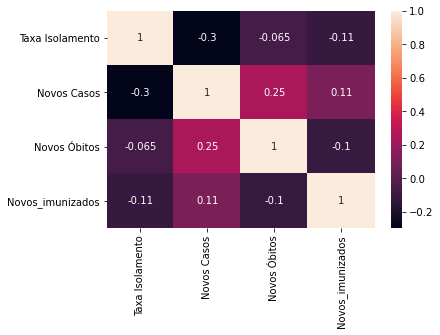

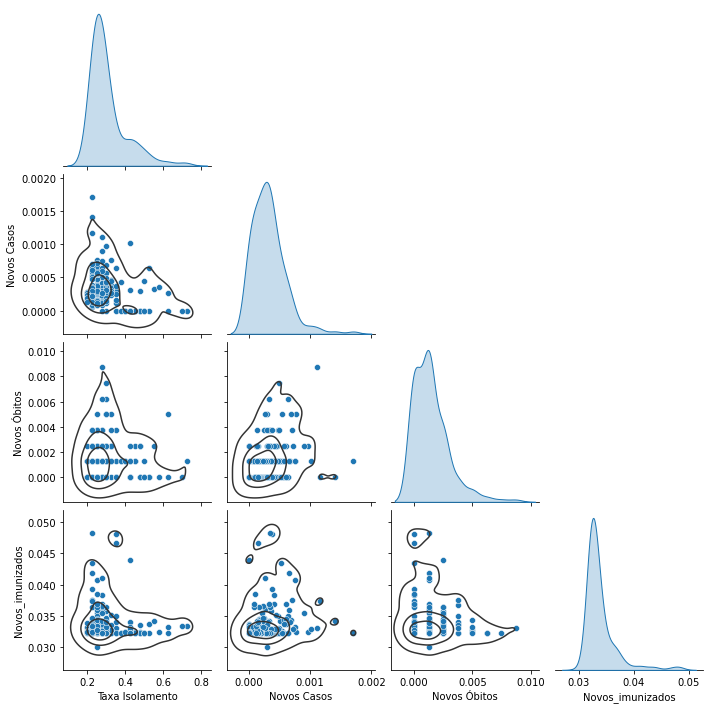

<Figure size 1440x648 with 0 Axes>

In [20]:
matriz_correlacoes("Botucatu")